In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [2]:

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# 14.2 합성곱 층

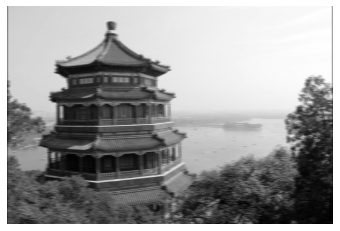

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.imshow(outputs[0,:,:,1], cmap="gray")
plt.axis("off")
plt.show()

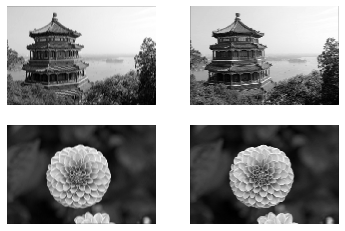

In [5]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.subplot(2,2,image_index * 2 + feature_map_index+1)
        plot_image(outputs[image_index,:,:,feature_map_index])
plt.show()

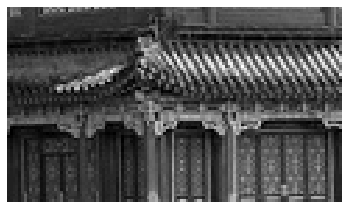

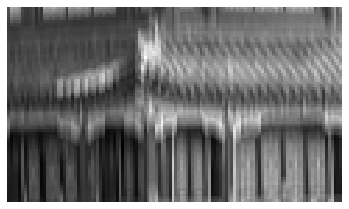

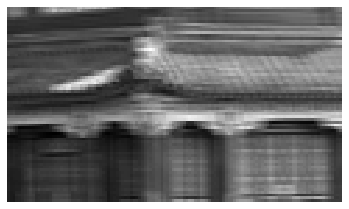

In [6]:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(images[0,:,:,0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0,:,:,feature_map_index]))
    plt.show()

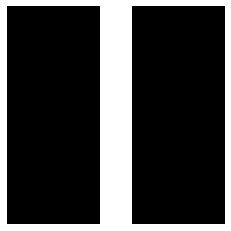

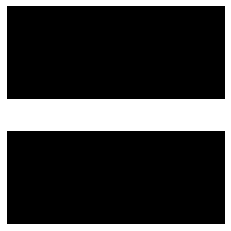

In [7]:
plot_image(filters[:,:,0,0])
plt.show()
plot_image(filters[:,:,0,1])
plt.show()

### Convolution Layer

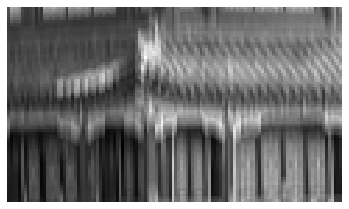

In [8]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")

plot_image(crop(outputs[0,:,:,0]))
plt.show()

### VALID vs SAME padding

In [9]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding=="SAME":
        return (input_size - 1) // strides+1
    else:
        return (input_size - kernel_size) // strides+1

In [15]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [16]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)

    
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_image = np.zeros(padded_shape, dtype=np.float32)
    padded_image[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_image




In [17]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size,strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images,kernel_size, strides))

conv_same.build(tf.TensorShape(images.shape))

conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())


# 14.3 풀링 층


## Max pooling

In [19]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [20]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


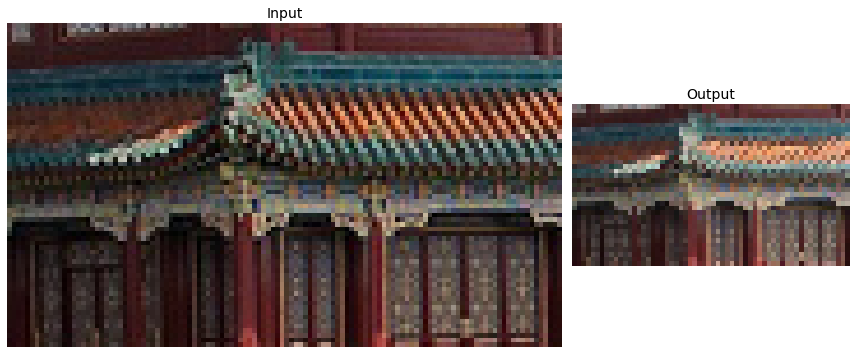

In [21]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## depth-wise pooling

In [22]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        return tf.nn.max_pool(inputs, ksize=(1,1,1,self.pool_size), strides=(1,1,1,self.pool_size), padding=self.padding)

In [23]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [24]:
depth_pool = keras.layers.Lambda(lambda X : tf.nn.max_pool(
    X, ksize=(1,1,1,3), strides=(1,1,1,3), padding="VALID"
))

with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape


TensorShape([2, 70, 120, 1])

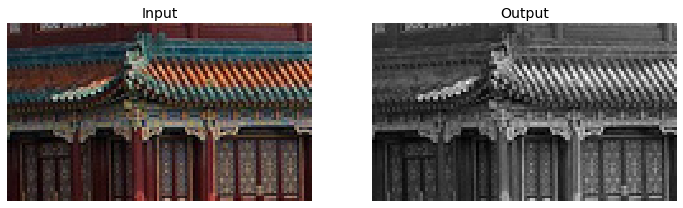

In [25]:

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average Pooling

In [26]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

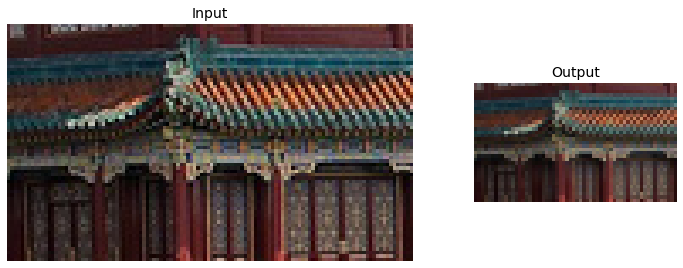

In [27]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling


In [28]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [29]:
output_global_avg2 = keras.layers.Lambda(lambda X : tf.reduce_mean(X, axis=[1,2]))
output_global_avg2(cropped_images)




<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

# 14.4 CNN 구조

In [31]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [35]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [36]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
 192/1719 [==>...........................] - ETA: 2:13 - loss: 1.4276 - accuracy: 0.4837

KeyboardInterrupt: 

In [42]:
import tensorflow as tf

print(tf.__version__)
# 1.14.0

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False